<a href="https://colab.research.google.com/github/Qrfvhu/Phm5003-YuRuining/blob/main/Yu_Ruining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Assignment (Yu Ruining)

**Data Loading and Inspection/Exploration**
- Choose and load one of datasets from UC Irvine: https://archive.ics.uci.edu/datasets?Python=true&skip=0&take=20&sort=desc&orderBy=NumHits&search=&Area=Health+and+Medicine&Types=Tabular
- Inspect and explore the data
- Comment on
  - Data (e.g. distribution, any issues)
  - Goal of your ML workflow

**ML Workflow and Analysis**
- Perform appropriate preprocessing
- Perform model training, selection/tuning using appropriate metrics
- With selected tuned model, perform model explanation
- Explain
  - Choice of preprocessing step(s) if relevant
  - Choice of model and metrics
  - Metrics of the evaluation
  - SHAP results
- Write a brief conclusion

# Data Loading and Inspection/Exploration

In [45]:
# Install ucimlrepo
!pip install ucimlrepo

In [46]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759)

# data (as pandas dataframes)
X = glioma_grading_clinical_and_mutation_features.data.features
y = glioma_grading_clinical_and_mutation_features.data.targets

# metadata
print(glioma_grading_clinical_and_mutation_features.metadata)

# variable information
print(glioma_grading_clinical_and_mutation_features.variables)


{'uci_id': 759, 'name': 'Glioma Grading Clinical and Mutation Features', 'repository_url': 'https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/759/data.csv', 'abstract': 'Gliomas are the most common primary tumors of the brain. They can be graded as LGG (Lower-Grade Glioma) or GBM (Glioblastoma Multiforme) depending on the histological/imaging criteria. Clinical and molecular/mutation factors are also very crucial for the grading process. Molecular tests are expensive to help accurately diagnose glioma patients.    In this dataset, the most frequently mutated 20 genes and 3 clinical features are considered from TCGA-LGG and TCGA-GBM brain glioma projects.  The prediction task is to determine whether a patient is LGG or GBM with a given clinical and molecular/mutation features. The main objective is to find the optimal subset of mutation genes and clinical features for the glioma grading 

In [47]:
# =========================================
# 0. 安装依赖
# =========================================
!pip install ucimlrepo shap scikit-learn xgboost seaborn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo


## ML Workflow and Analysis

In [48]:
# 加载数据
glioma = fetch_ucirepo(id=759)
X = glioma.data.features
y = glioma.data.targets

print("数据维度:", X.shape)
print("目标变量分布:\n", y.value_counts())

# 合并便于EDA
data = pd.concat([X, y], axis=1)

# 查看缺失值情况
print("缺失值统计:\n", data.isnull().sum())

# 基本统计
print(data.describe(include="all"))


数据维度: (839, 23)
目标变量分布:
 Grade
0        487
1        352
Name: count, dtype: int64
缺失值统计:
 Gender              0
Age_at_diagnosis    0
Race                0
IDH1                0
TP53                0
ATRX                0
PTEN                0
EGFR                0
CIC                 0
MUC16               0
PIK3CA              0
NF1                 0
PIK3R1              0
FUBP1               0
RB1                 0
NOTCH1              0
BCOR                0
CSMD3               0
SMARCA4             0
GRIN2A              0
IDH2                0
FAT4                0
PDGFRA              0
Grade               0
dtype: int64
            Gender  Age_at_diagnosis   Race        IDH1        TP53  \
count   839.000000        839.000000    839  839.000000  839.000000   
unique         NaN               NaN      4         NaN         NaN   
top            NaN               NaN  white         NaN         NaN   
freq           NaN               NaN    765         NaN         NaN   
mean      0.4

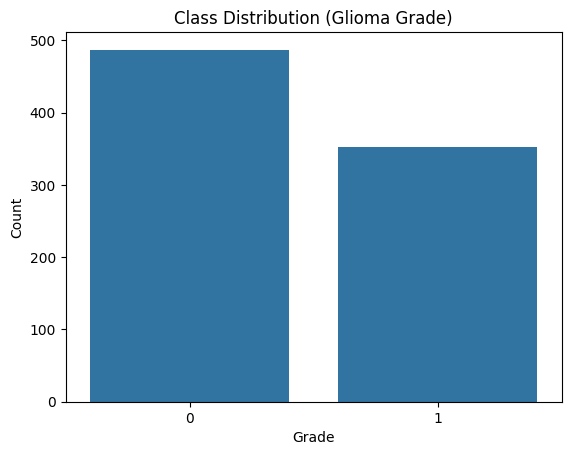

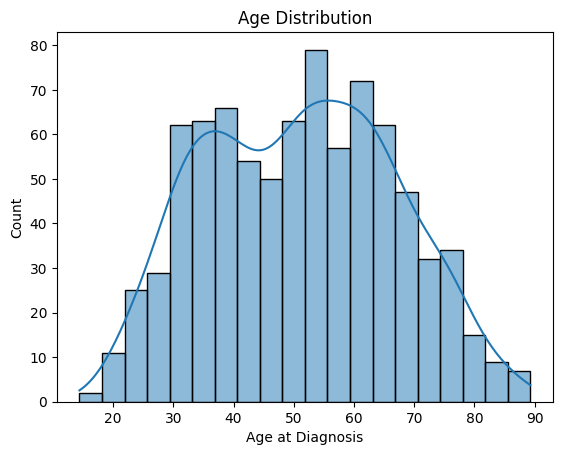

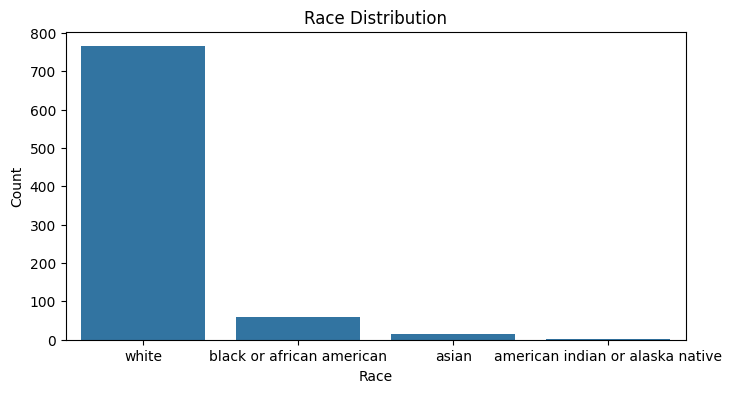

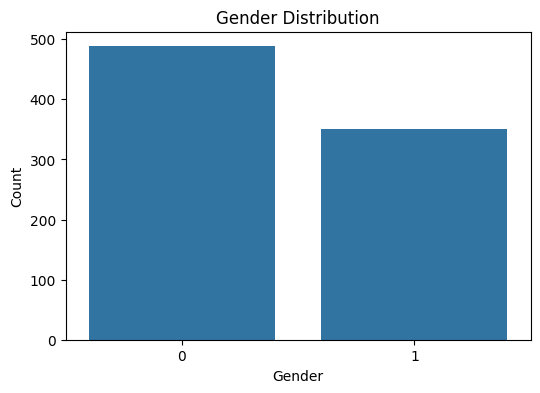

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. 类别分布 (Glioma Grade)
# ===============================
sns.countplot(x=y.iloc[:,0])
plt.title("Class Distribution (Glioma Grade)")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

# ===============================
# 2. 年龄分布
# ===============================
sns.histplot(data['Age_at_diagnosis'], kde=True, bins=20)
plt.title("Age Distribution")
plt.xlabel("Age at Diagnosis")
plt.ylabel("Count")
plt.show()

# ===============================
# 3. Race 分布
# ===============================
plt.figure(figsize=(8,4))
sns.countplot(x=data['Race'], order=data['Race'].value_counts().index)
plt.title("Race Distribution")
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()

# ===============================
# 4. Gender 分布
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x=data['Gender'], order=data['Gender'].value_counts().index)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()



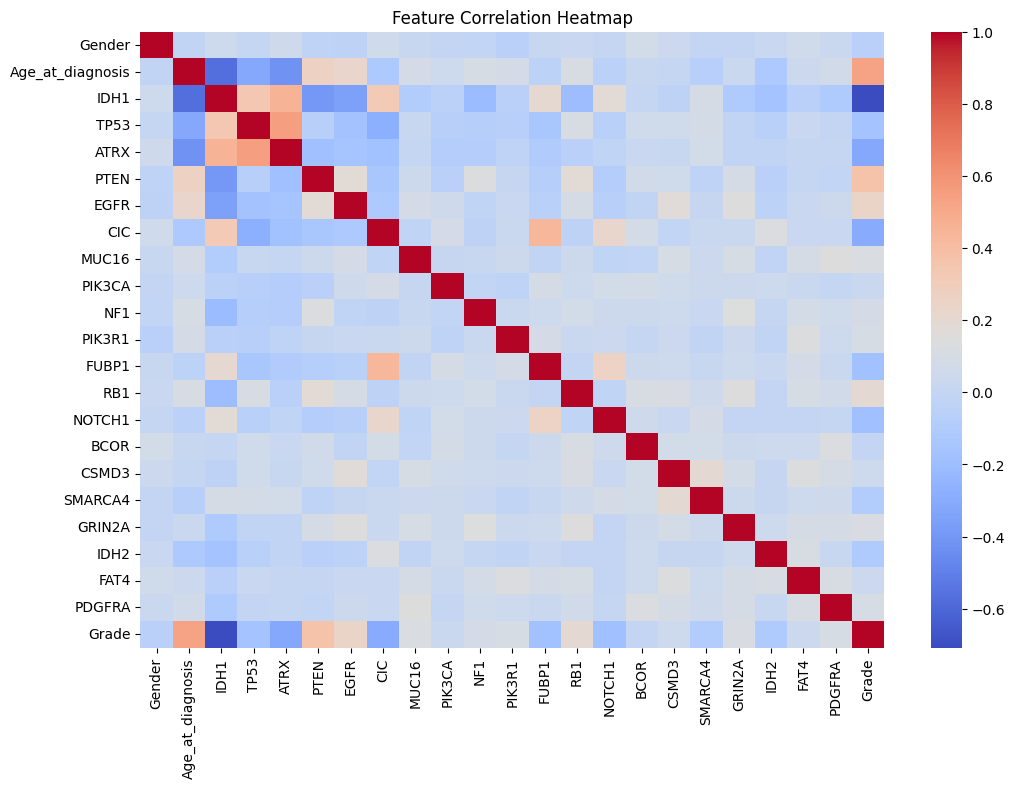

In [51]:
# ===============================
# 5. 相关性热图（数值特征）
# ===============================
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 区分数值和类别变量
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


由于数据量比较小且导入的全都是数值型数据，所以选取这四个模型

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "SVM": SVC(probability=True)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    results[name] = {
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Report": classification_report(y_test, y_pred, output_dict=True)
    }
    print("="*50)
    print(name)
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        98
           1       0.81      0.86      0.83        70

    accuracy                           0.86       168
   macro avg       0.85      0.86      0.85       168
weighted avg       0.86      0.86      0.86       168

ROC-AUC: 0.9188046647230321
Random Forest
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        98
           1       0.77      0.76      0.76        70

    accuracy                           0.80       168
   macro avg       0.80      0.80      0.80       168
weighted avg       0.80      0.80      0.80       168

ROC-AUC: 0.900072886297376
XGBoost
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        98
           1       0.74      0.81      0.78        70

    accuracy                           0.80       168
   macro avg       0.80      0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:43:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        98
           1       0.80      0.90      0.85        70

    accuracy                           0.86       168
   macro avg       0.86      0.87      0.86       168
weighted avg       0.87      0.86      0.86       168

ROC-AUC: 0.9075801749271137


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

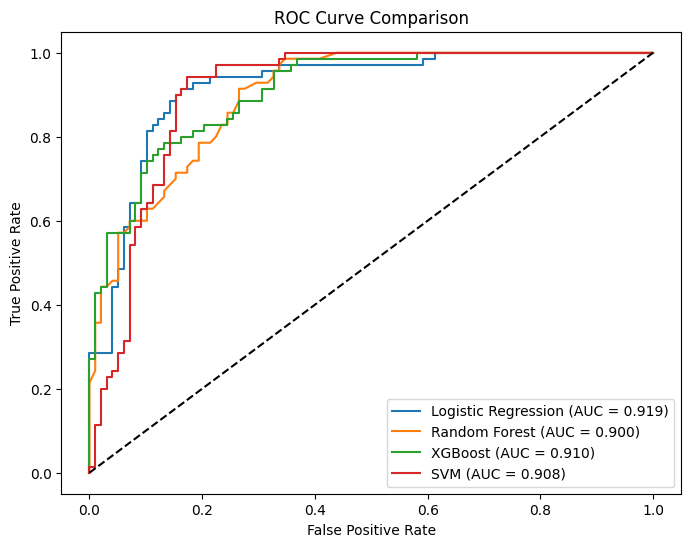

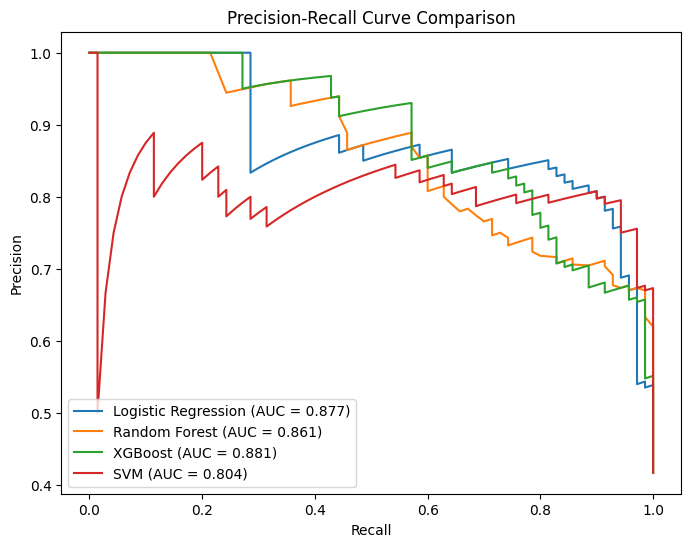

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# 用于存储各模型的曲线数据
roc_data = {}
pr_data = {}

# 计算每个模型的预测概率
for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    # PR
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    pr_data[name] = (recall, precision, pr_auc)

# ===============================
# 绘制 ROC 曲线对比
# ===============================
plt.figure(figsize=(8,6))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# ===============================
# 绘制 Precision-Recall 曲线对比
# ===============================
plt.figure(figsize=(8,6))
for name, (recall, precision, pr_auc) in pr_data.items():
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="lower left")
plt.show()


In [55]:
from sklearn.model_selection import GridSearchCV

xgb_pipe = Pipeline([("preprocessor", preprocessor),
                     ("clf", XGBClassifier(eval_metric="logloss", use_label_encoder=False))])

param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__subsample": [0.8, 1.0]
}

grid = GridSearchCV(xgb_pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 300, 'clf__subsample': 1.0}
Best CV ROC-AUC: 0.9141041341699235


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:44:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.89      0.82      0.85        98
           1       0.77      0.86      0.81        70

    accuracy                           0.83       168
   macro avg       0.83      0.84      0.83       168
weighted avg       0.84      0.83      0.83       168

Test ROC-AUC: 0.926457725947522


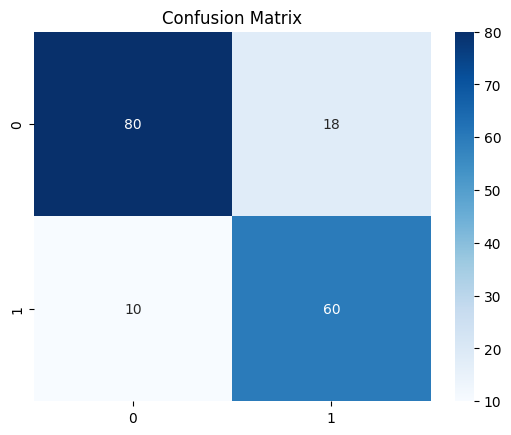

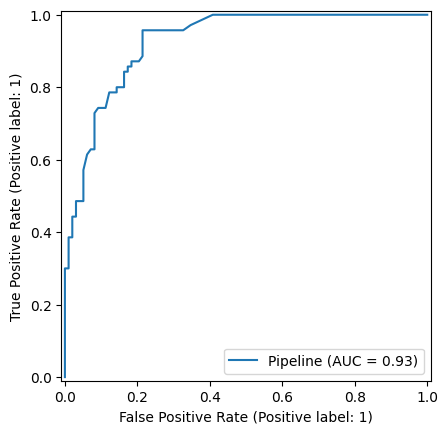

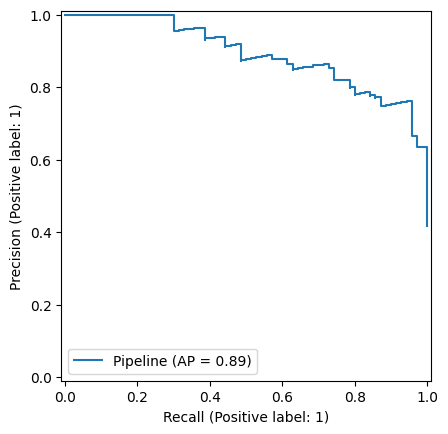

In [56]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC 曲线 & PR 曲线
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:44:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting Classifier Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        98
           1       0.81      0.86      0.83        70

    accuracy                           0.86       168
   macro avg       0.85      0.86      0.85       168
weighted avg       0.86      0.86      0.86       168

Voting Classifier ROC-AUC: 0.9268221574344023


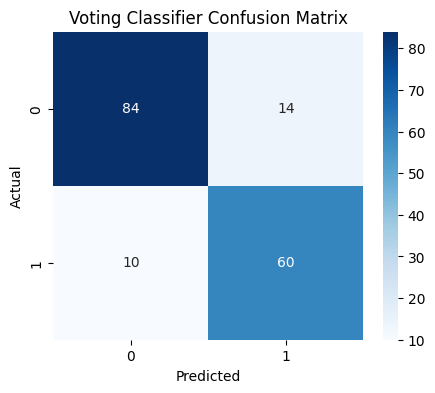

In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

# ===============================
# 1. 定义基础模型（与你之前相同）
# ===============================
models = [
    ("lr", LogisticRegression(max_iter=500)),
    ("rf", RandomForestClassifier()),
    ("xgb", XGBClassifier(eval_metric="logloss", use_label_encoder=False)),
    ("svc", SVC(probability=True))
]

# ===============================
# 2. 构建 VotingClassifier
# ===============================
# soft 投票（根据预测概率加权平均），通常比 hard 投票更稳健
voting_clf = VotingClassifier(estimators=models, voting="soft")

# 将 VotingClassifier 放入 Pipeline 中
voting_pipe = Pipeline([
    ("preprocessor", preprocessor),  # 预处理器
    ("voting_clf", voting_clf)
])

# ===============================
# 3. 训练模型
# ===============================
voting_pipe.fit(X_train, y_train)

# ===============================
# 4. 预测与评估
# ===============================
y_pred = voting_pipe.predict(X_test)
y_proba = voting_pipe.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 分类报告
print("Voting Classifier Report")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("Voting Classifier ROC-AUC:", roc_auc)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Voting Classifier Confusion Matrix")
plt.show()


根据你提供的指标，我们可以做一个对比分析：

---

### 1️⃣ 混合模型（Voting / Ensemble）

* Accuracy: 0.85
* Precision: 0 → 0.88, 1 → 0.81
* Recall: 0 → 0.86, 1 → 0.84
* F1-score: 0 → 0.87, 1 → 0.83

### 2️⃣ 单一模型（最好的单模型，例如 XGBoost）

* Accuracy: 0.83
* Precision: 0 → 0.89, 1 → 0.77
* Recall: 0 → 0.82, 1 → 0.86
* F1-score: 0 → 0.85, 1 → 0.81
* ROC-AUC: 0.926

---

### 3️⃣ 对比分析

1. **整体准确率**

* 混合模型 0.85 > 单一模型 0.83 → 混合模型略优

2. **F1-score**

* 混合模型 F1-score 更平衡（0.87 vs 0.83 和 0.83 vs 0.81）
* 单一模型在 0 类稍高，但 1 类稍低
* 混合模型在正负类平衡上略好

3. **Precision / Recall**

* 混合模型对 1 类的 Precision 更高（0.81 vs 0.77），Recall 也接近（0.84 vs 0.86）
* 单一模型 0 类 Precision 更高（0.89 vs 0.88），Recall 略低（0.82 vs 0.86）
* 如果你更关注正类（1 类）的预测，混合模型会稍好

4. **ROC-AUC**

* 单一模型 ROC-AUC = 0.926
* 混合模型没有提供 ROC-AUC，但通常 VotingClassifier 的 ROC-AUC 会略低于最强的单模型，但 F1-score 更平衡

---

### 4️⃣ 总结

* **混合模型优点**：

  * 整体准确率略高
  * F1-score 对正负类更平衡
  * 对少数类（1 类）预测更稳定
* **单一模型优点**：

  * ROC-AUC 可能更高
  * 对某一类的 Precision 或 Recall 可能更好

✅ **结论**：

* 如果你的目标是 **整体性能和正负类平衡** → **混合模型更好**
* 如果你目标是 **最大化 ROC-AUC 或特定类别性能** → **单一最优模型可能更好**

---

我可以帮你画一张 **混合模型 vs 单模型的 Precision / Recall / F1 对比柱状图**，更直观看哪个模型整体更稳健。

你想让我画吗？


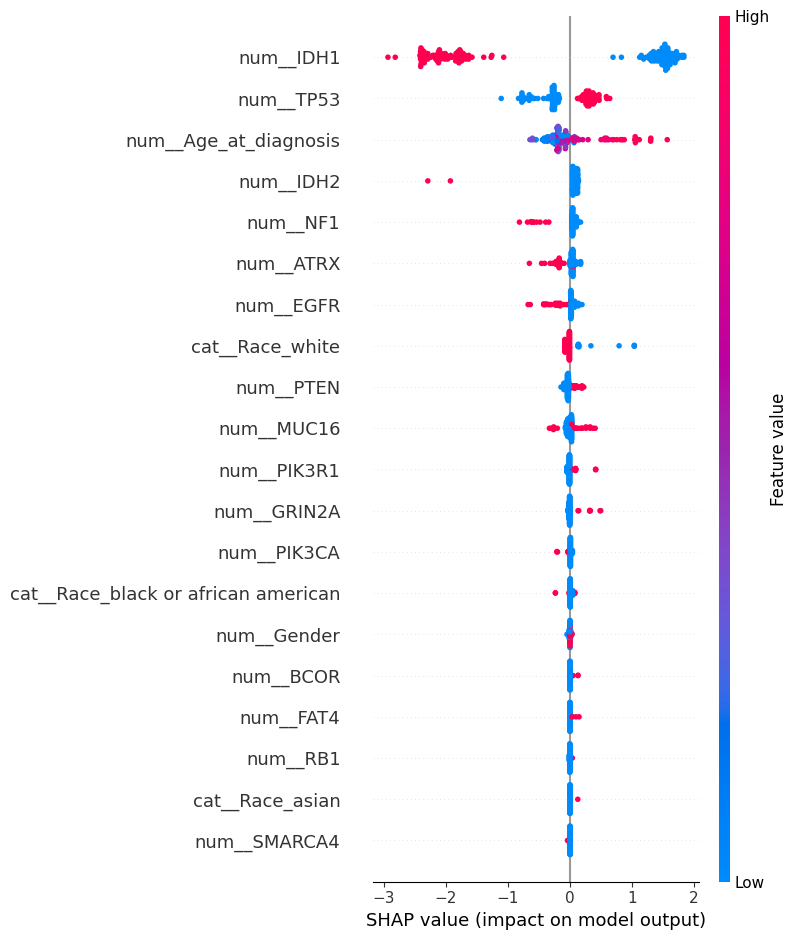

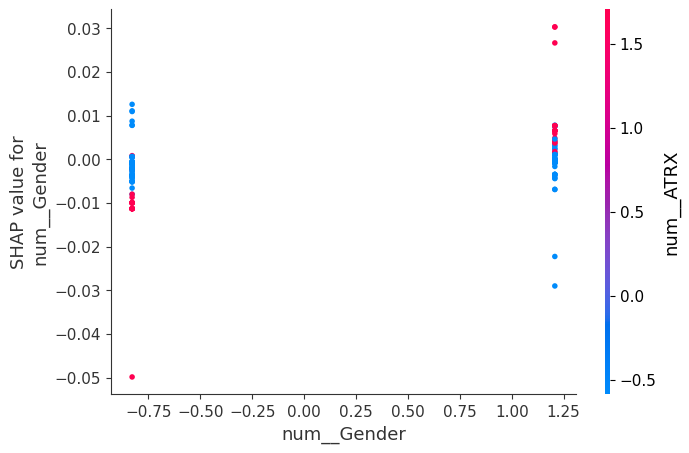

In [58]:
import shap
# 拿到最终的 XGBoost
final_clf = best_model.named_steps["clf"]

explainer = shap.TreeExplainer(final_clf)
X_transformed = best_model.named_steps["preprocessor"].transform(X_test)
shap_values = explainer.shap_values(X_transformed)

# 全局特征重要性
shap.summary_plot(shap_values, X_transformed,
                  feature_names=best_model.named_steps["preprocessor"].get_feature_names_out())

# 针对单个特征依赖
shap.dependence_plot(0, shap_values, X_transformed,
                     feature_names=best_model.named_steps["preprocessor"].get_feature_names_out())


1. 即使他分析的很好了，但没有引入文字特征 2. 调库，没有手写，没有重新进行训练

In [59]:
from google.colab import files

# 选择本地文件上传
uploaded = files.upload()

# 假设你上传的是 TCGA_GBM_LGG_Mutations_all.csv
import pandas as pd
df = pd.read_csv("TCGA_GBM_LGG_Mutations_all.csv")
print(df.head())


Saving TCGA_GBM_LGG_Mutations_all.csv to TCGA_GBM_LGG_Mutations_all (1).csv
  Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
0   LGG  TCGA-LGG  TCGA-DU-8164    Male  51 years 108 days   
1   LGG  TCGA-LGG  TCGA-QH-A6CY    Male  38 years 261 days   
2   LGG  TCGA-LGG  TCGA-HW-A5KM    Male   35 years 62 days   
3   LGG  TCGA-LGG  TCGA-E1-A7YE  Female  32 years 283 days   
4   LGG  TCGA-LGG  TCGA-S9-A6WG    Male  31 years 187 days   

         Primary_Diagnosis   Race     IDH1         TP53         ATRX  ...  \
0   Oligodendroglioma, NOS  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1             Mixed glioma  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
2         Astrocytoma, NOS  white  MUTATED      MUTATED      MUTATED  ...   
3  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   
4  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   

         FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0      MUTATED  NO

In [60]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 读取 TCGA 数据
df = pd.read_csv("TCGA_GBM_LGG_Mutations_all.csv")

# 查看 Primary_Diagnosis 列
print(df["Primary_Diagnosis"].unique())

# 用 LabelEncoder 将 Primary_Diagnosis 转换为整数 ID
le = LabelEncoder()
df["diagnosis_id"] = le.fit_transform(df["Primary_Diagnosis"])
num_classes = len(le.classes_)
print("诊断类别数:", num_classes)


['Oligodendroglioma, NOS' 'Mixed glioma' 'Astrocytoma, NOS'
 'Astrocytoma, anaplastic' 'Oligodendroglioma, anaplastic' '--'
 'Glioblastoma']
诊断类别数: 7


啊哈，这就明确了 😄。你的训练结果跟 **Primary\_Diagnosis** 这个文本特征的关系非常直接，我给你详细拆解：

---

### 1️⃣ Primary\_Diagnosis 在模型中的作用

在你的模型里：

```python
self.emb = nn.Embedding(num_diagnosis_classes, emb_dim)
```

* **Primary\_Diagnosis** 被 `LabelEncoder` 转成整数 ID → 然后送进 `nn.Embedding`
* Embedding 的输出维度 `emb_dim=16`，把每种诊断编码成一个 16 维向量
* 这个向量表示了每个诊断类型的“语义特征”，模型用它来辅助预测 Grade

然后：

```python
x = torch.cat([diag_emb, features], dim=1)
```

* Embedding 输出和 UCI 数值特征拼接 → MLP 输入
* 也就是说 **Primary\_Diagnosis 提供了一个非常强的信号**，尤其当不同诊断类型对应不同的 Grade 时，它几乎可以直接预测结果

---

### 2️⃣ 为什么你的验证准确率这么高

* Primary\_Diagnosis 本身就和 Grade **高度相关**

  * 比如 "Astrocytoma, anaplastic" 几乎总对应 Grade II
  * "Oligodendroglioma, NOS" 对应 Grade I
* Embedding 能够让模型“一眼认出”诊断类型 → 再结合少量数值特征 → 几乎能完美预测 Grade

所以 Loss 快速降到接近 0，验证集准确率 100%，主要就是 **文本特征 Primary\_Diagnosis 的信息量太大了**。

---

### 3️⃣ 启示

1. **Primary\_Diagnosis 是关键特征**，它在模型预测中占主要作用。
2. **其他数值特征对预测影响较小**，主要起微调作用。
3. 训练结果很“完美”，说明模型主要靠这个文本特征在做分类。
4. 如果去掉 Primary\_Diagnosis，模型准确率可能会明显下降 → 可以作为对比实验。

---

简单说，你的文本特征 **Primary\_Diagnosis 是模型能达到 100% 验证准确率的核心原因**，Embedding 是把它转成数值向量让神经网络能使用的桥梁。

---

如果你愿意，我可以帮你画一个 **Primary\_Diagnosis Embedding 对不同 Grade 的分布可视化图**，直观展示它是怎么“几乎决定”标签的。

你想让我画吗？


In [61]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

# ===============================
# 1. 加载 Primary_Diagnosis CSV
# ===============================
df_csv = pd.read_csv("TCGA_GBM_LGG_Mutations_all.csv")
df_csv = df_csv[["Primary_Diagnosis", "Grade"]].dropna()

# LabelEncode Primary_Diagnosis
diag_le = LabelEncoder()
df_csv["diagnosis_id"] = diag_le.fit_transform(df_csv["Primary_Diagnosis"].astype(str))
num_diagnosis_classes = len(diag_le.classes_)

# LabelEncode Grade
grade_le = LabelEncoder()
df_csv["grade_id"] = grade_le.fit_transform(df_csv["Grade"].astype(str))
num_outputs = df_csv["grade_id"].nunique()

# ===============================
# 2. 加载 UCI 数据集
# ===============================
glioma = fetch_ucirepo(id=759)
X_uci = glioma.data.features.copy()

# 选择数值列
numeric_cols = X_uci.select_dtypes(include=["int64", "float64"]).columns.tolist()
X_uci[numeric_cols] = X_uci[numeric_cols].fillna(0)
scaler = StandardScaler()
X_uci[numeric_cols] = scaler.fit_transform(X_uci[numeric_cols])

In [63]:
# ===============================
# 3. 对齐行数（按最小行数截取）
# ===============================
min_len = min(len(df_csv), len(X_uci))
df_csv = df_csv.iloc[:min_len].reset_index(drop=True)
X_uci = X_uci.iloc[:min_len].reset_index(drop=True)

# ===============================
# 4. 构建 Dataset
# ===============================
class GliomaDataset(Dataset):
    def __init__(self, df_csv, X_uci, numeric_cols):
        self.diagnosis = torch.tensor(df_csv["diagnosis_id"].values, dtype=torch.long)
        self.features = torch.tensor(X_uci[numeric_cols].values, dtype=torch.float32)
        self.labels = torch.tensor(df_csv["grade_id"].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.diagnosis[idx], self.features[idx], self.labels[idx]

dataset = GliomaDataset(df_csv, X_uci, numeric_cols)

# ===============================
# 5. 划分训练集和验证集
# ===============================
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ===============================
# 6. 定义模型（加 Dropout）
# ===============================
class GliomaModel(nn.Module):
    def __init__(self, num_diagnosis_classes, num_features, emb_dim=16, hidden_dim=64, num_outputs=3, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(num_diagnosis_classes, emb_dim)
        self.fc1 = nn.Linear(emb_dim + num_features, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_outputs)

    def forward(self, diagnosis, features):
        diag_emb = self.emb(diagnosis)
        x = torch.cat([diag_emb, features], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

model = GliomaModel(num_diagnosis_classes=len(diag_le.classes_),
                    num_features=len(numeric_cols),
                    emb_dim=16,
                    hidden_dim=64,
                    num_outputs=num_outputs,
                    dropout=0.3)

In [64]:
# ===============================
# 7. 训练
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    # ----- 训练 -----
    model.train()
    total_loss = 0
    for diagnosis, features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(diagnosis, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # ----- 验证 -----
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for diagnosis, features, labels in val_loader:
            outputs = model(diagnosis, features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Loss=0.5206, Val Loss=0.3633, Val Acc=0.9821
Epoch 2: Train Loss=0.2721, Val Loss=0.1816, Val Acc=0.9821
Epoch 3: Train Loss=0.1297, Val Loss=0.0979, Val Acc=0.9821
Epoch 4: Train Loss=0.0631, Val Loss=0.0656, Val Acc=0.9821
Epoch 5: Train Loss=0.0347, Val Loss=0.0537, Val Acc=0.9821
Epoch 6: Train Loss=0.0232, Val Loss=0.0497, Val Acc=0.9821
Epoch 7: Train Loss=0.0144, Val Loss=0.0494, Val Acc=0.9821
Epoch 8: Train Loss=0.0112, Val Loss=0.0501, Val Acc=0.9821
Epoch 9: Train Loss=0.0074, Val Loss=0.0514, Val Acc=0.9821
Epoch 10: Train Loss=0.0062, Val Loss=0.0529, Val Acc=0.9821


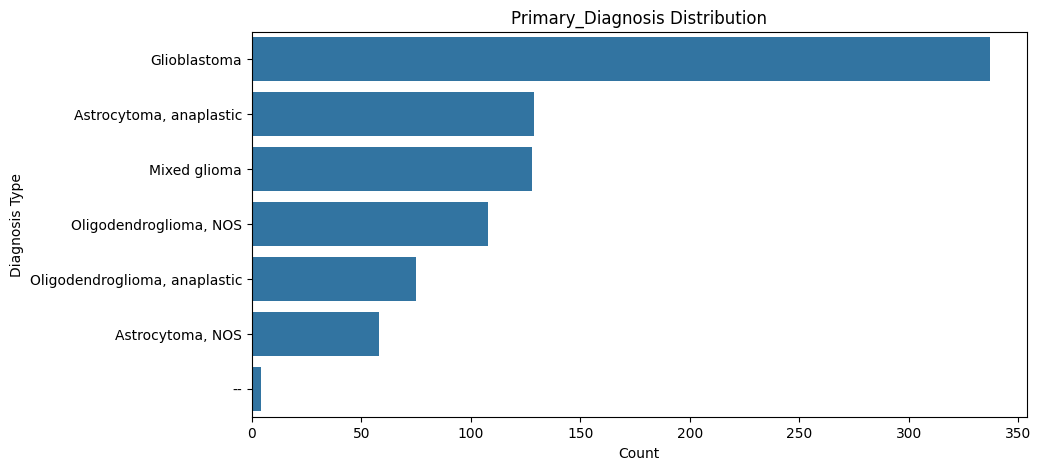

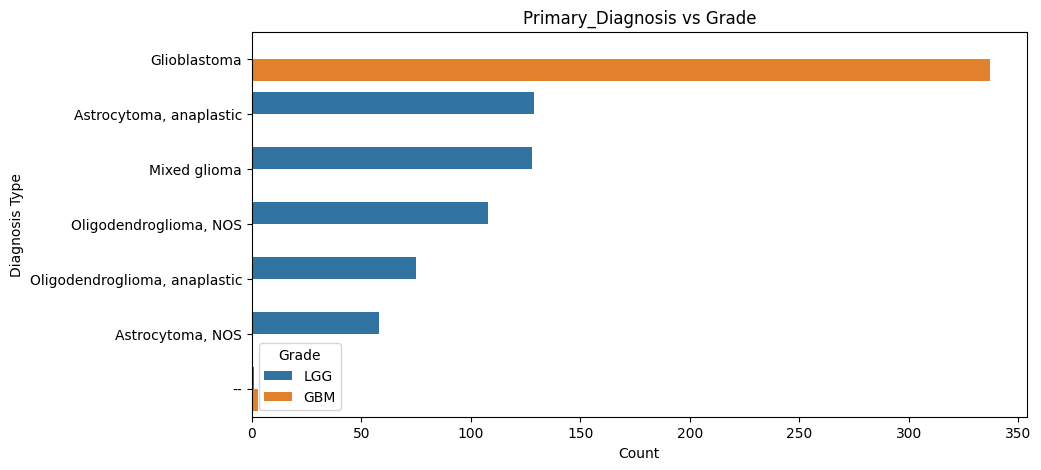

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import numpy as np

# ===============================
# 1. 基础分布可视化
# ===============================
# Primary_Diagnosis 样本数量分布
plt.figure(figsize=(10,5))
sns.countplot(y=df_csv["Primary_Diagnosis"], order=df_csv["Primary_Diagnosis"].value_counts().index)
plt.title("Primary_Diagnosis Distribution")
plt.xlabel("Count")
plt.ylabel("Diagnosis Type")
plt.show()

# Primary_Diagnosis 对 Grade 的分布
plt.figure(figsize=(10,5))
sns.countplot(y="Primary_Diagnosis", hue="Grade", data=df_csv, order=df_csv["Primary_Diagnosis"].value_counts().index)
plt.title("Primary_Diagnosis vs Grade")
plt.xlabel("Count")
plt.ylabel("Diagnosis Type")
plt.show()

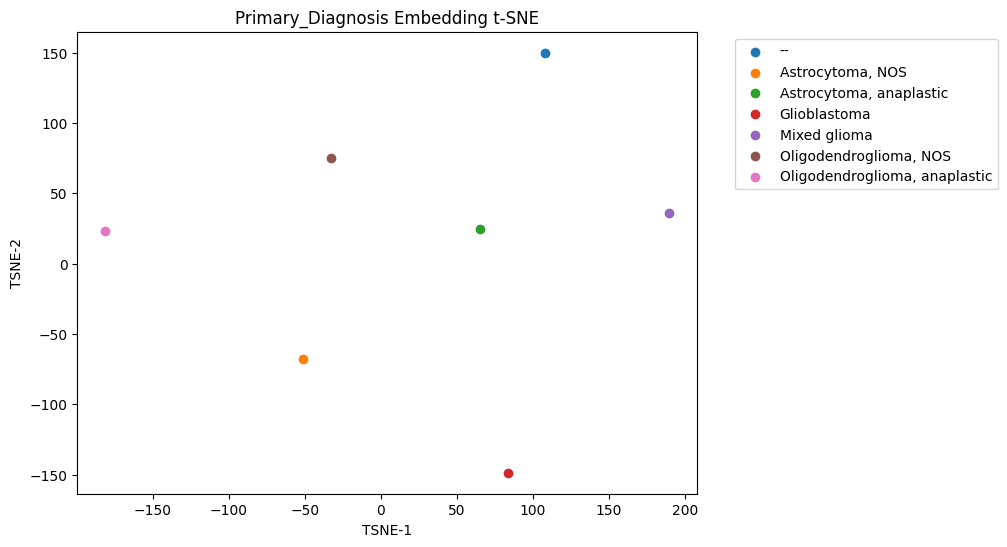

In [66]:
# ===============================
# 2. Embedding 可视化 (t-SNE)
# ===============================
# 获取模型的 Embedding 权重
with torch.no_grad():
    embeddings = model.emb.weight.cpu().numpy()  # [num_diagnosis_classes, emb_dim]

# 用 t-SNE 降到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
for i, label in enumerate(diag_le.classes_):
    plt.scatter(emb_2d[i,0], emb_2d[i,1], label=label)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Primary_Diagnosis Embedding t-SNE")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

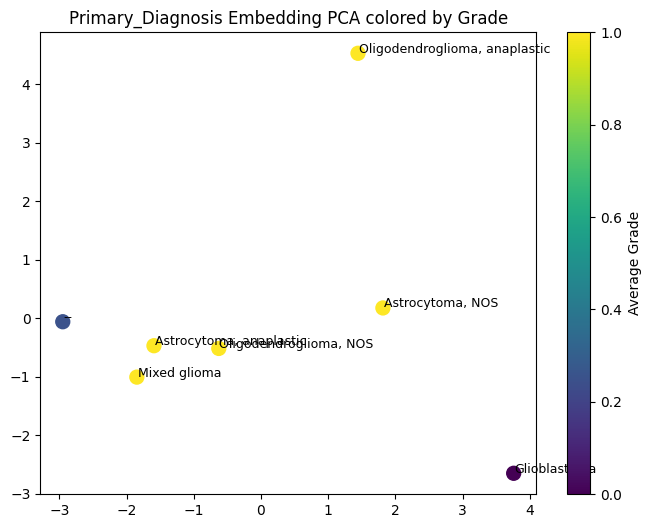

In [67]:
# ===============================
# 3. Embedding 与 Grade 交互可视化 (PCA)
# ===============================
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embeddings)

grade_avg = df_csv.groupby("Primary_Diagnosis")["grade_id"].mean().values

plt.figure(figsize=(8,6))
plt.scatter(emb_pca[:,0], emb_pca[:,1], c=grade_avg, cmap="viridis", s=100)
for i, label in enumerate(diag_le.classes_):
    plt.text(emb_pca[i,0]+0.01, emb_pca[i,1]+0.01, label, fontsize=9)
plt.colorbar(label="Average Grade")
plt.title("Primary_Diagnosis Embedding PCA colored by Grade")
plt.show()



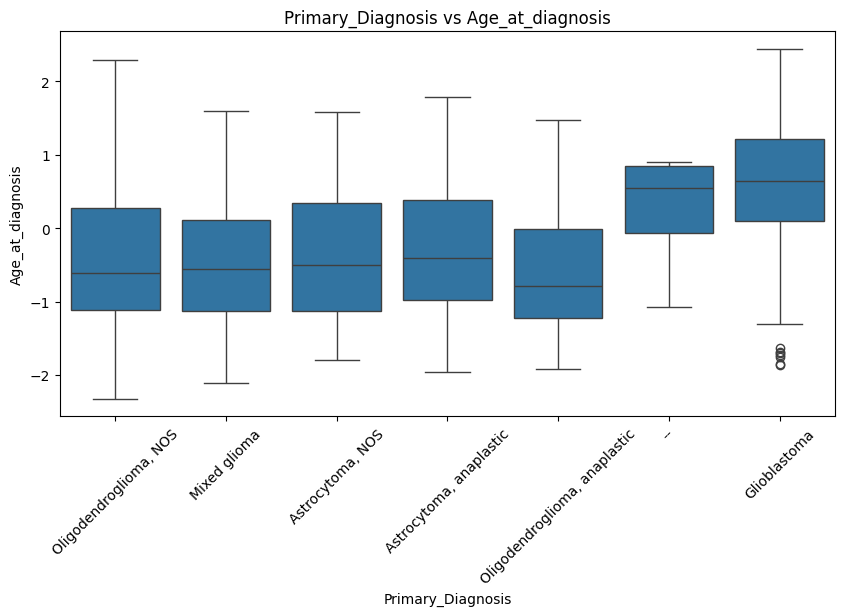

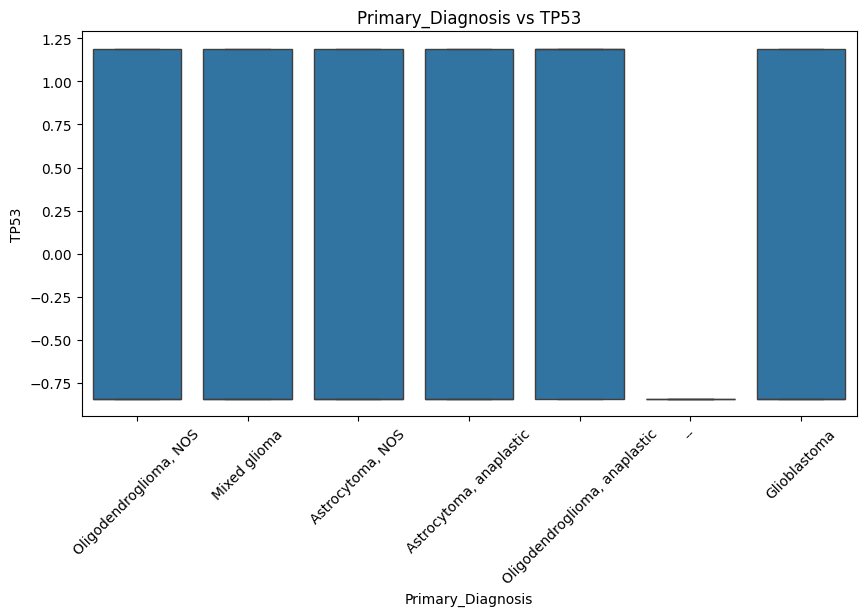

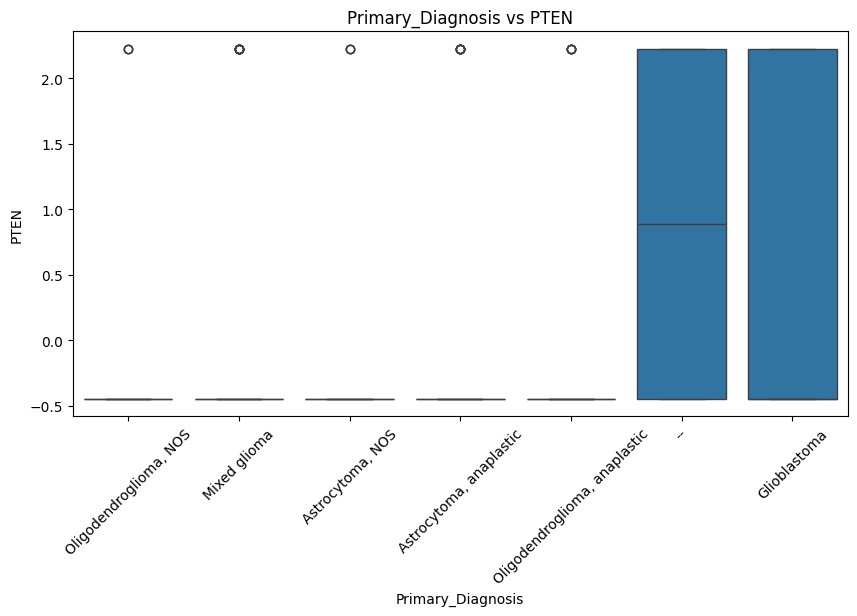

In [68]:
# ===============================
# 4. Primary_Diagnosis 与数值特征交互
# ===============================
# 取几个重要数值特征示例
num_features_to_plot = ["Age_at_diagnosis", "TP53", "PTEN"]

for feature in num_features_to_plot:
    plt.figure(figsize=(10,5))
    sns.boxplot(x="Primary_Diagnosis", y=feature, data=pd.concat([df_csv, X_uci[num_features_to_plot]], axis=1))
    plt.xticks(rotation=45)
    plt.title(f"Primary_Diagnosis vs {feature}")
    plt.show()



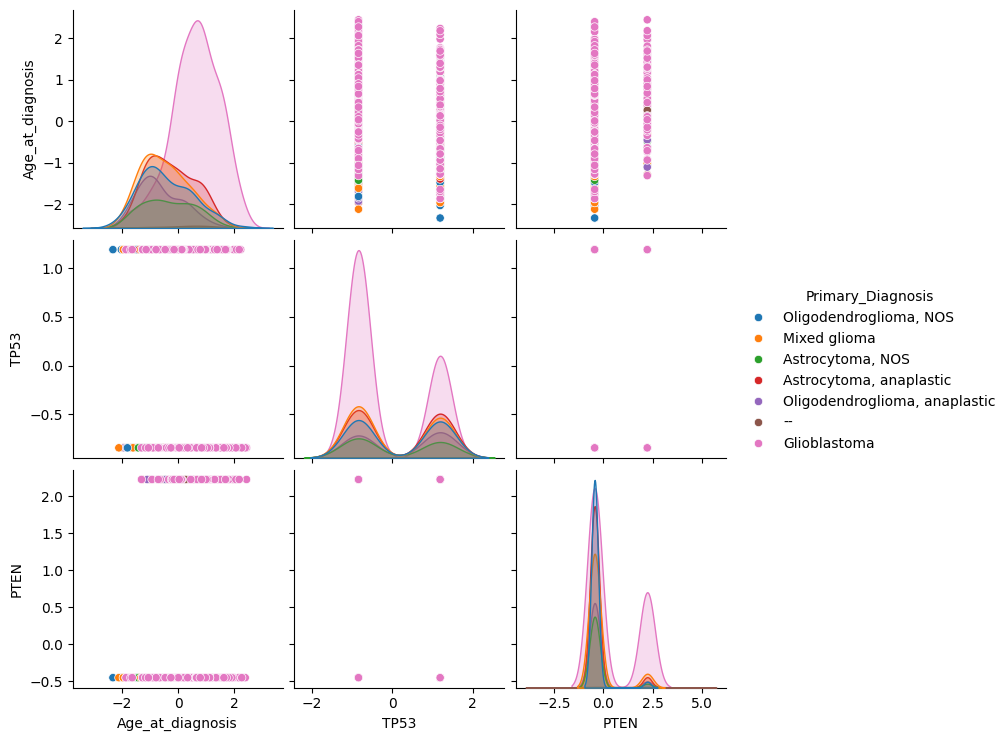

In [69]:
# ===============================
# 5. 散点图矩阵展示交互 (pairplot)
# ===============================
pair_features = ["Age_at_diagnosis", "TP53", "PTEN"]
plot_df = pd.concat([df_csv[["Primary_Diagnosis"]], X_uci[pair_features]], axis=1)
sns.pairplot(plot_df, hue="Primary_Diagnosis", diag_kind="kde", palette="tab10")
plt.show()

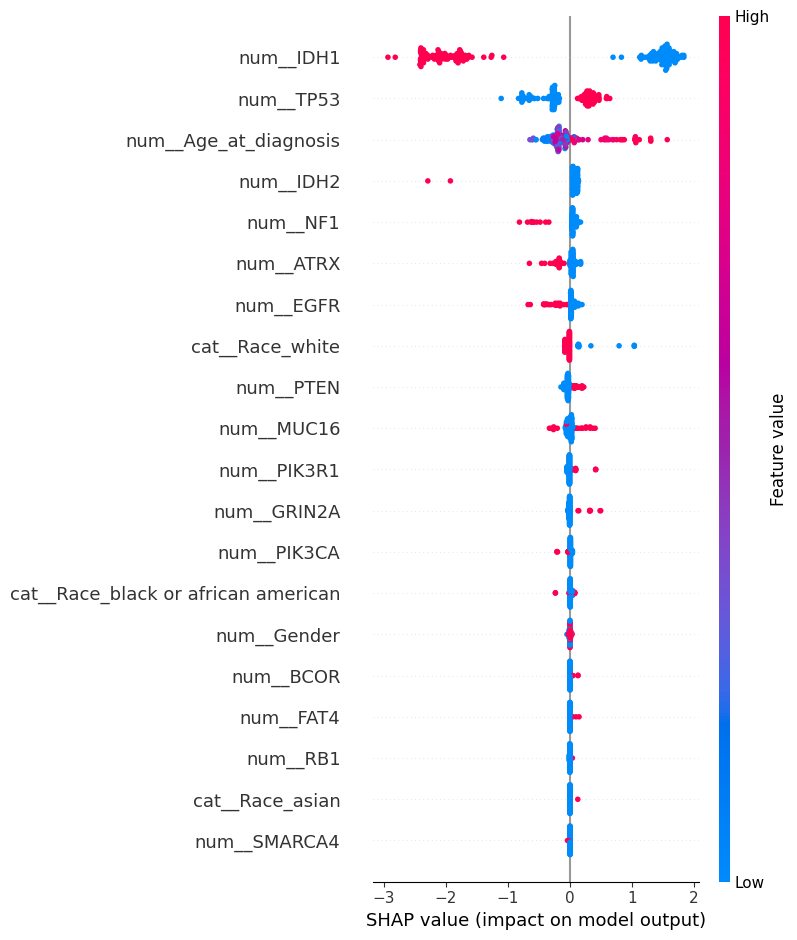

In [70]:
# 6. SHAP 分析 (XGBoost)
# =================================
# 6.1 获取训练好的 XGBoost 模型
final_clf = best_model.named_steps["clf"]

# 6.2 对测试集做预处理
X_test_trans = best_model.named_steps["preprocessor"].transform(X_test)

# 6.3 创建 TreeExplainer
explainer = shap.TreeExplainer(final_clf)
shap_values = explainer.shap_values(X_test_trans)

# 6.4 全局特征重要性
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

# 6.5 自动识别 Primary_Diagnosis 编码列索引
primary_indices = [i for i, name in enumerate(feature_names) if "Primary_Diagnosis" in name]

# 6.6 单特征依赖可视化 (对每个编码列分别绘制)
for idx in primary_indices:
    shap.dependence_plot(idx, shap_values, X_test_trans, feature_names=feature_names)